### Importing Libs

In [5]:
import os

import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import pathlib


### Loading images

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
data_dir = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    fname="flower_photos",
    untar=True,
)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 25s 0us/step


In [ ]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

In [ ]:
CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"]
)
CLASS_NAMES

array(['tulips', 'sunflowers', 'daisy', 'roses', 'dandelion'],
      dtype='<U10')

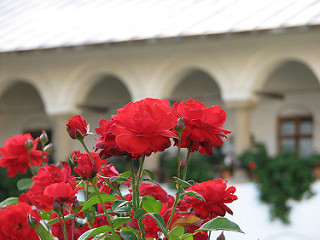

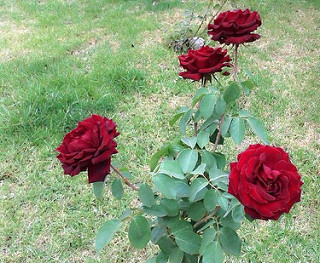

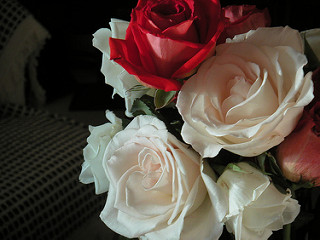

In [13]:
roses = list(data_dir.glob("roses/*"))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

### Load using tf.preprocessing

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

In [14]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [15]:
train_data_gen = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=list(CLASS_NAMES),
)

Found 3670 images belonging to 5 classes.


In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)  # TODO 1b
        plt.imshow(image_batch[n])  # TODO 1b
        plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis("off")

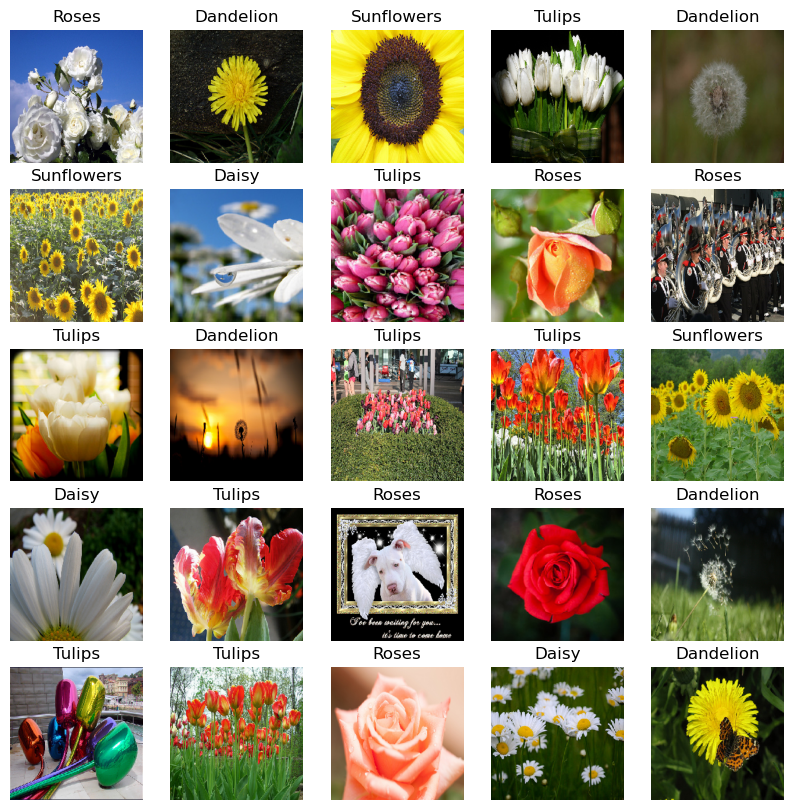

In [17]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

### Load using tf.data

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir / "*/*"))

In [19]:
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/8014734302_65c6e83bb4_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3711892138_b8c953fdc1_z.jpg'
b'/root/.keras/datasets/flower_photos/tulips/17202535346_ab828e779b.jpg'
b'/root/.keras/datasets/flower_photos/tulips/2427626706_ffdf697f84_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/678714585_addc9aaaef.jpg'


2023-05-18 21:12:16.034003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3670]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:12:16.034316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3670]
	 [[{{node Placeholder/_0}}]]


In [22]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) 
    return parts[-2] == CLASS_NAMES 

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) 
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [23]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [24]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False]


2023-05-18 21:13:28.484757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3670]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:13:28.485111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3670]
	 [[{{node Placeholder/_0}}]]


### Basics for training

In [31]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # TODO 3a

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [32]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

2023-05-18 21:16:47.378281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3670]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:16:47.378775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3670]
	 [[{{node Placeholder/_0}}]]
2023-05-18 21:16:48.798819: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2023-05-18 21:16:48.848378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unex

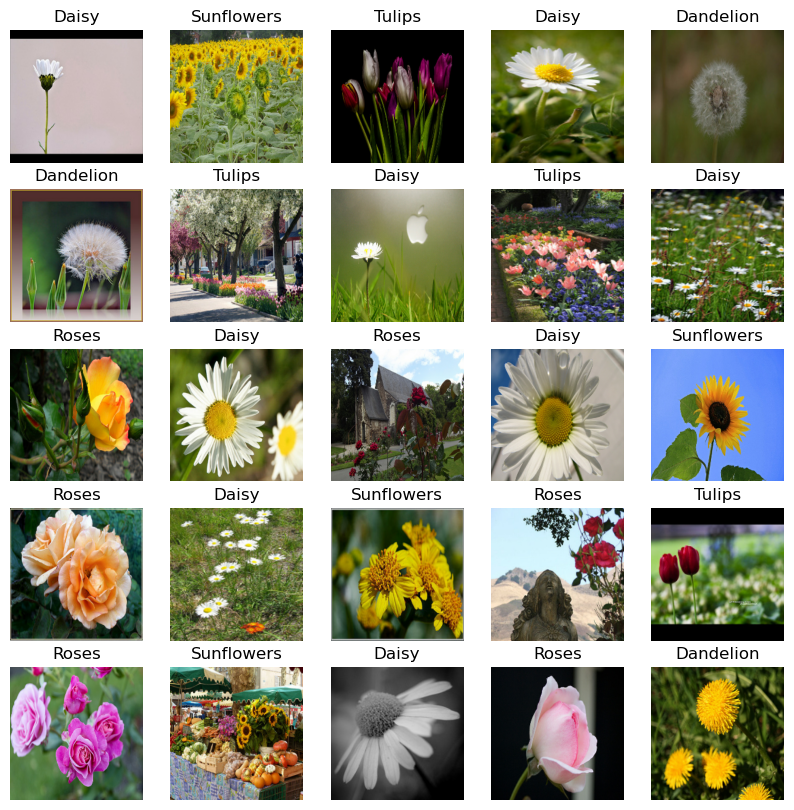

In [33]:
show_batch(image_batch.numpy(), label_batch.numpy())